# Solving Simflied Thick Ptychography Model Least Squares Problem

This tutorial demonstrates how to use `thickptypy` to set up and solve a least_squares problem to reconstuct a thick sample.

The wave inversion is posed as a least-squares problem:

\begin{equation}
E(n) = \frac{1}{2} \sum_{i=1}^{N} \| p_i(n) - p_{\text{obs},i} \|^2_2,
\end{equation}

where $p_i$ and $p_{\text{obs},i}$ are the simulated and observed exit waves for the $i$-th probe position in Ptychography. 

$n(x,z)$ defines the refractive index of the volume

### 1. Import Libraries: Sample Space, Least Squares Solver and Visualisation

In [ ]:
from thickptypy.sample_space.sample_space import SampleSpace
from thickptypy.reconstruction.least_squares import LeastSquaresSolver
from thickptypy.utils.visualisations import Visualisation

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [13]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "disk"                 # Disk probe
wave_number = 5e-1                   # Wavenumber (micrometers^-1)

# Continuous space limits (micrometers)
xlims = [0,1500]                    # X limits in micrometers
zlims = [0,5000]                   # Z limits in micrometers
continuous_dimensions = [
    xlims,
    zlims
    ]                     # Continuous dimensions in micrometers

# Discrete space parameters
propagation_slices = 50             # Number of z slices
probe_dimensions = [15]             # Discrete Probe dimensions
scan_points = 110                   # Large number of probes needed
step_size = 1                       # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"Pixels for compatibility with Diamond thin-sample simulation:")
print(f"nx = {min_nx}")
print(f"(These are also the minimum values for the discrete space limits)")

# Number of pixels in x directions
nx= 130
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    propagation_slices
    ]   

Pixels for compatibility with Diamond thin-sample simulation:
nx = 125
(These are also the minimum values for the discrete space limits)


### 3. Create Sample Space, Add Objects and Visualise it.

Add rectangles with specified refractive indices to the sample space.

In [14]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    wave_number,            # wavenumber in 1/nm
)
sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space)

Summary of the scan (continuous):
    Sample space x: 1500 um
    Sample space z: 5000 um
    Probe Diameter: 174.42 um
    Number of scan points: 110
    Max Overlap: 162.88 um 



In [16]:
delta = 1e-4
beta = 1e-6j
refractive_index1 = - delta + beta
refractive_index2 = - 0.9 * delta + 1.1*beta
guassian_blur = 0.0

sample_space.add_object('rectangle', refractive_index1, side_length=200, centre=(600,300),depth=300,guassian_blur=guassian_blur)
sample_space.add_object('rectangle', refractive_index1, side_length=500, centre=(800,4600),depth=50,guassian_blur=guassian_blur)
sample_space.add_object('rectangle', refractive_index2, side_length=200, centre=(1200,4000),depth=50,guassian_blur=guassian_blur)
sample_space.add_object('rectangle', refractive_index2, side_length=500, centre=(500,2500),depth=1000,guassian_blur=guassian_blur)
sample_space.generate_sample_space()

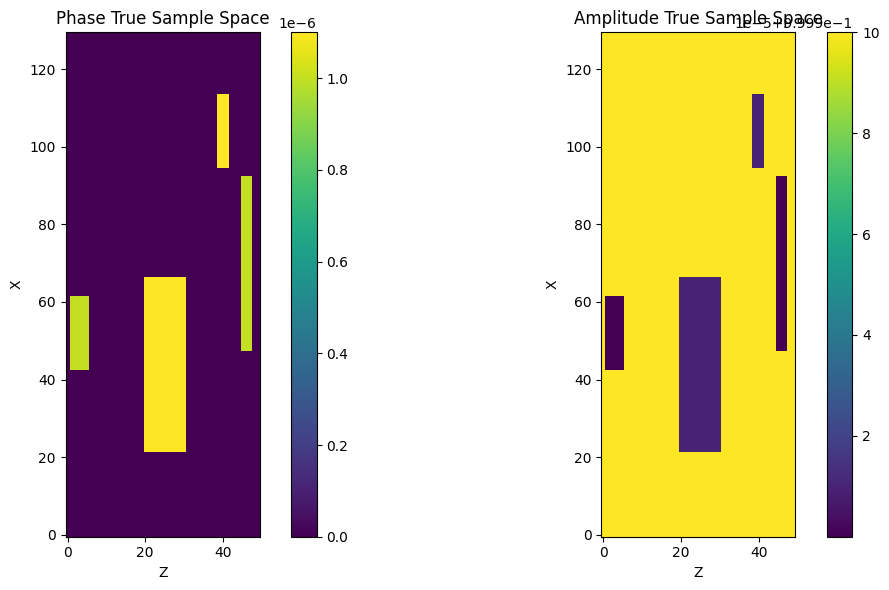

In [18]:
# Plot the true sample space
title = "True Sample Space"
visualisation.plot(sample_space.n_true, title=title)

### 6. Solve Least Squares to Reconstruct Simulated Sample Space


In [6]:
# Solve full system all-at-once or iteratively
least_squares = LeastSquaresSolver(sample_space,full_system_solver=False)

Initializing Least Squares Solver...
Solving the true forward problem once to generate the dataset...
True Forward Solution computed in 2.40 seconds.


True Object


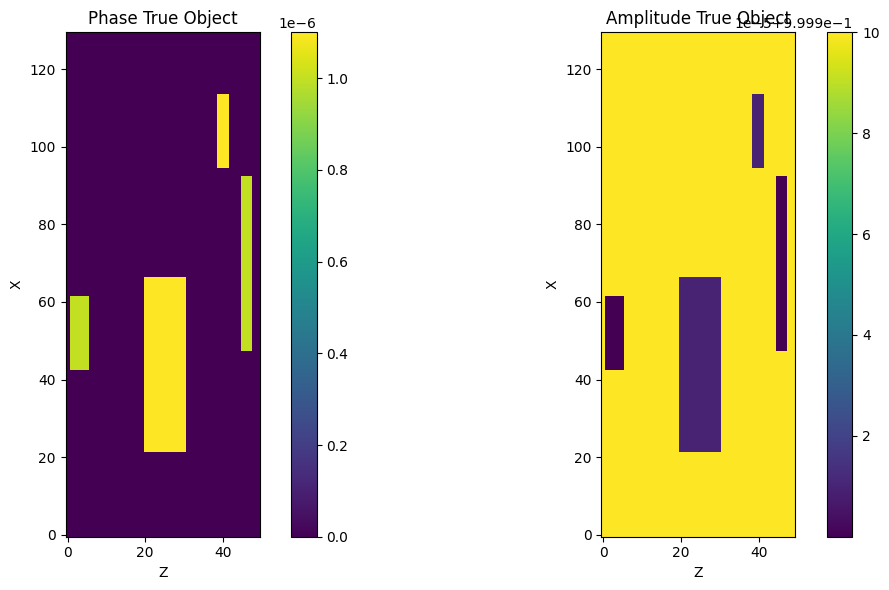

Iteration 1/50
    RMSE: 3.227787506113108e-05
    Reconstructed Object


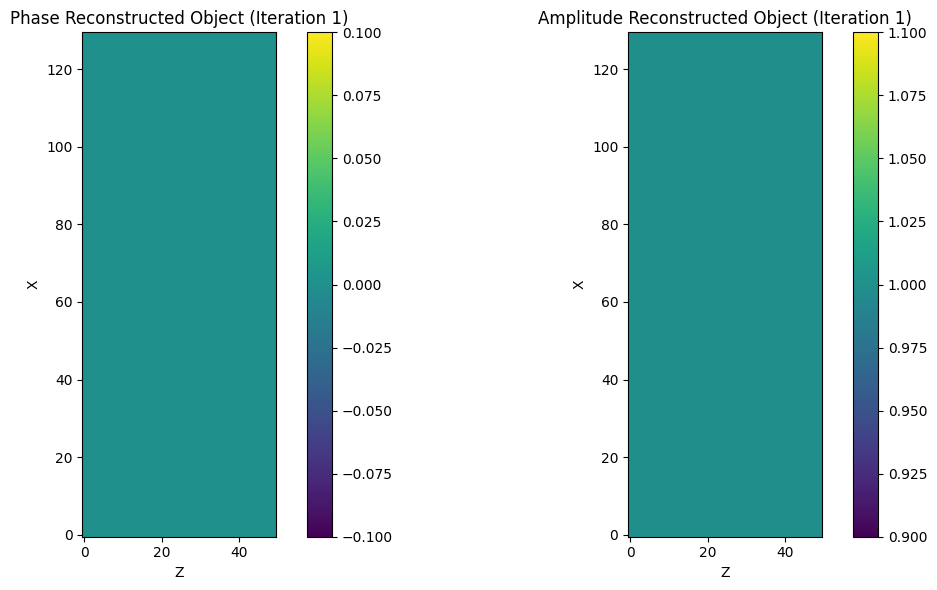

    Iteration 1 took 8.62 seconds.
Iteration 2/50
    RMSE: 3.169376982793779e-05
    Iteration 2 took 61.98 seconds.
Iteration 3/50
    RMSE: 3.1180069256886606e-05
    Iteration 3 took 66.23 seconds.
Iteration 4/50
    RMSE: 3.0726637760236945e-05
    Iteration 4 took 55.63 seconds.
Iteration 5/50
    RMSE: 3.0326893964370087e-05
    Iteration 5 took 52.90 seconds.
Iteration 6/50
    RMSE: 2.997493175392584e-05
    Iteration 6 took 40.84 seconds.
Iteration 7/50
    RMSE: 2.966539912008035e-05
    Iteration 7 took 21.11 seconds.
Iteration 8/50
    RMSE: 2.9393458237290857e-05
    Iteration 8 took 19.09 seconds.
Iteration 9/50
    RMSE: 2.9154751728665067e-05
    Iteration 9 took 22.25 seconds.
Iteration 10/50
    RMSE: 2.89453692631718e-05
    Reconstructed Object


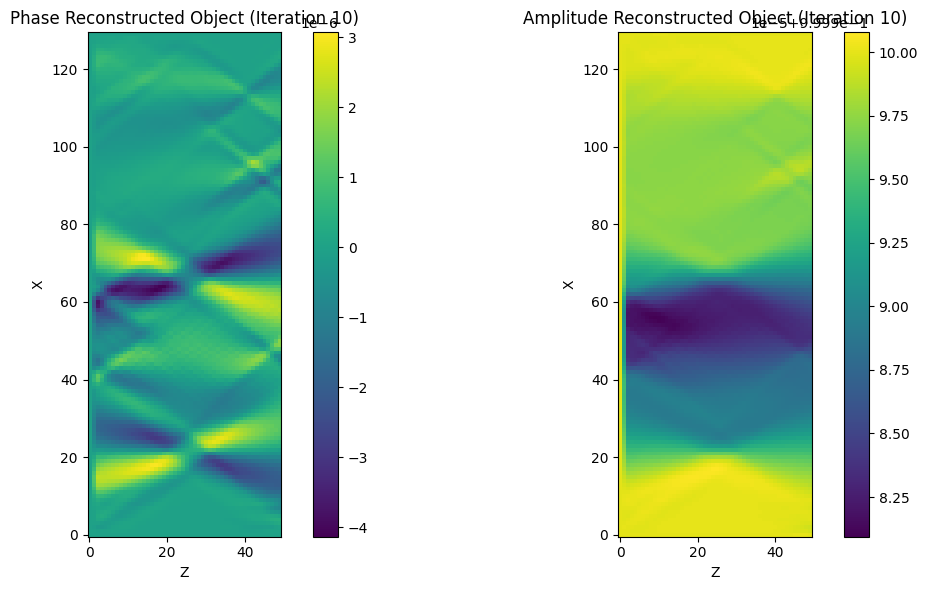

    Iteration 10 took 20.81 seconds.
Iteration 11/50
    RMSE: 2.8761814025419528e-05
    Iteration 11 took 17.56 seconds.
Iteration 12/50
    RMSE: 2.8600969381491162e-05
    Iteration 12 took 21.03 seconds.
Iteration 13/50
    RMSE: 2.8460066202421937e-05
    Iteration 13 took 18.49 seconds.
Iteration 14/50
    RMSE: 2.833665128930272e-05
    Iteration 14 took 18.97 seconds.
Iteration 15/50
    RMSE: 2.8228557268572902e-05
    Iteration 15 took 17.43 seconds.
Iteration 16/50
    RMSE: 2.8133874227138133e-05
    Iteration 16 took 20.03 seconds.
Iteration 17/50
    RMSE: 2.805092324909351e-05
    Iteration 17 took 18.15 seconds.
Iteration 18/50
    RMSE: 2.7978231901747516e-05
    Iteration 18 took 20.49 seconds.
Iteration 19/50
    RMSE: 2.791451158999679e-05
    Iteration 19 took 18.10 seconds.
Iteration 20/50
    RMSE: 2.7858636534814787e-05
    Reconstructed Object


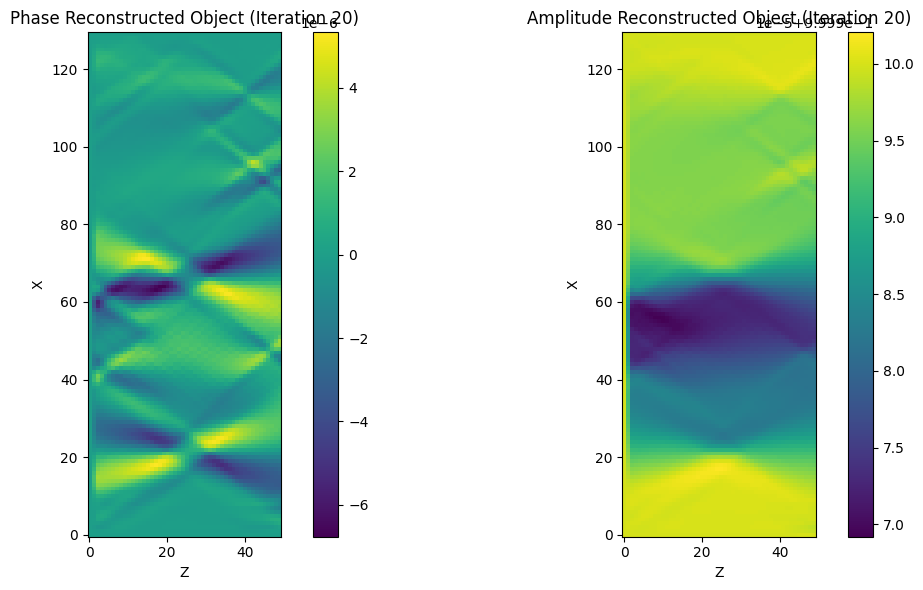

    Iteration 20 took 19.16 seconds.
Iteration 21/50
    RMSE: 2.7809623902244583e-05
    Iteration 21 took 17.98 seconds.
Iteration 22/50
    RMSE: 2.7766614283268063e-05
    Iteration 22 took 23.09 seconds.
Iteration 23/50
    RMSE: 2.7728851328948173e-05
    Iteration 23 took 27.53 seconds.
Iteration 24/50
    RMSE: 2.7695659133352376e-05
    Iteration 24 took 22.22 seconds.
Iteration 25/50
    RMSE: 2.7666416751182994e-05
    Iteration 25 took 17.67 seconds.
Iteration 26/50
    RMSE: 2.7640532600268948e-05
    Iteration 26 took 19.76 seconds.
Iteration 27/50
    RMSE: 2.7617428097762104e-05
    Iteration 27 took 17.59 seconds.
Iteration 28/50
    RMSE: 2.7596544223411197e-05
    Iteration 28 took 22.00 seconds.
Iteration 29/50
    RMSE: 2.75773739360916e-05
    Iteration 29 took 17.73 seconds.
Iteration 30/50
    RMSE: 2.755949834047068e-05
    Reconstructed Object


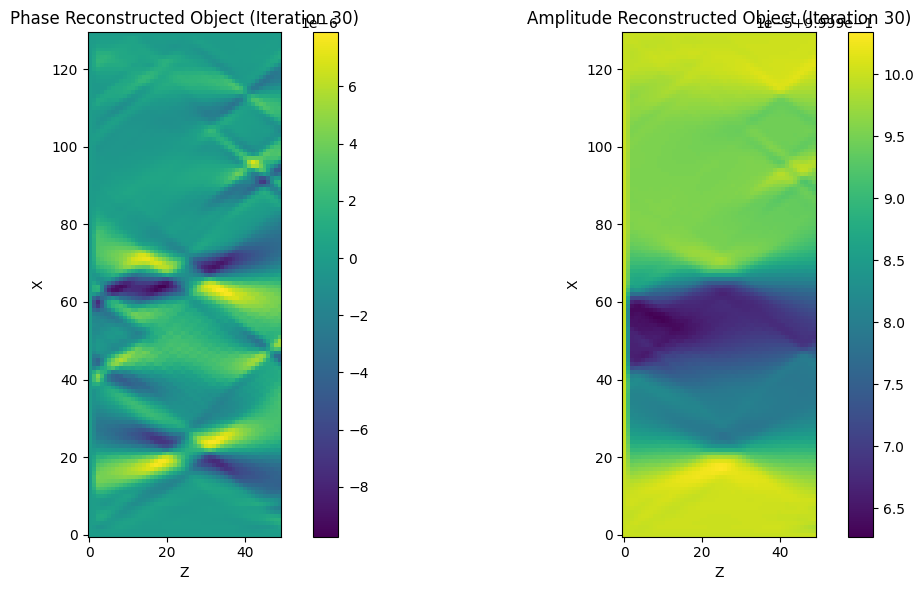

    Iteration 30 took 20.23 seconds.
Iteration 31/50
    RMSE: 2.75425972374779e-05
    Iteration 31 took 24.92 seconds.
Iteration 32/50
    RMSE: 2.752643057116761e-05
    Iteration 32 took 19.21 seconds.
Iteration 33/50
    RMSE: 2.7510810150572193e-05
    Iteration 33 took 17.46 seconds.
Iteration 34/50
    RMSE: 2.7495577215794412e-05
    Iteration 34 took 23.88 seconds.
Iteration 35/50
    RMSE: 2.7480588895217802e-05
    Iteration 35 took 17.64 seconds.
Iteration 36/50
    RMSE: 2.7465711185172492e-05
    Iteration 36 took 19.49 seconds.
Iteration 37/50
    RMSE: 2.745081651619814e-05
    Iteration 37 took 27.64 seconds.
Iteration 38/50
    RMSE: 2.7435785886820722e-05
    Iteration 38 took 20.74 seconds.
Iteration 39/50
    RMSE: 2.7420517474811745e-05
    Iteration 39 took 18.44 seconds.
Iteration 40/50
    RMSE: 2.740494528899796e-05
    Reconstructed Object


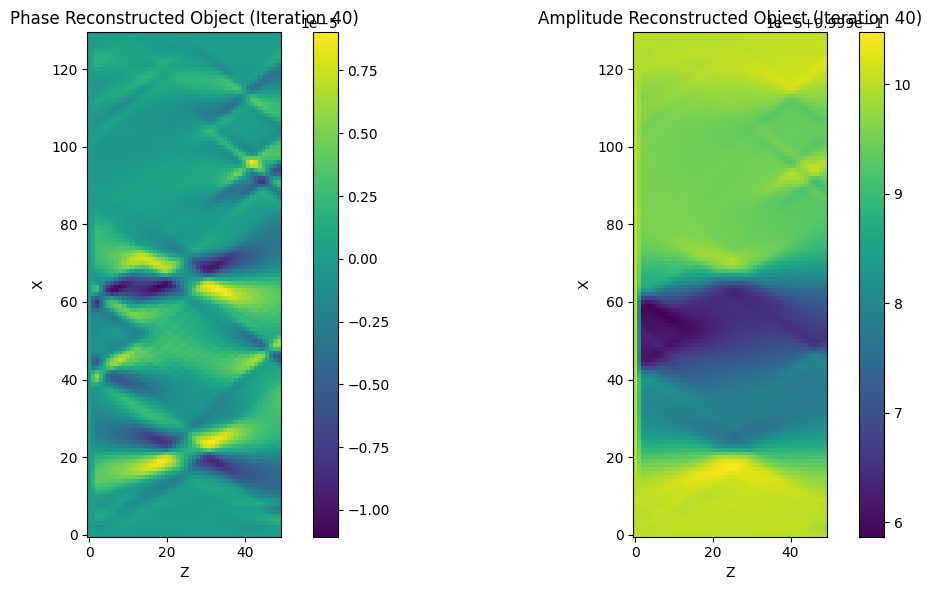

    Iteration 40 took 23.10 seconds.
Iteration 41/50
    RMSE: 2.738907132768531e-05
    Iteration 41 took 20.08 seconds.
Iteration 42/50
    RMSE: 2.737300821982903e-05
    Iteration 42 took 17.02 seconds.
Iteration 43/50
    RMSE: 2.7357010161808118e-05
    Iteration 43 took 21.95 seconds.
Iteration 44/50
    RMSE: 2.734144638605689e-05
    Iteration 44 took 20.74 seconds.
Iteration 45/50
    RMSE: 2.7326688957271782e-05
    Iteration 45 took 19.72 seconds.
Iteration 46/50
    RMSE: 2.7312974392589772e-05
    Iteration 46 took 21.30 seconds.
Iteration 47/50
    RMSE: 2.7300350053345095e-05
    Iteration 47 took 19.74 seconds.
Iteration 48/50
    RMSE: 2.7288727015450015e-05
    Iteration 48 took 18.78 seconds.
Iteration 49/50
    RMSE: 2.7277963507830327e-05
    Iteration 49 took 19.06 seconds.
Iteration 50/50
    RMSE: 2.7267919263794014e-05
    Reconstructed Object


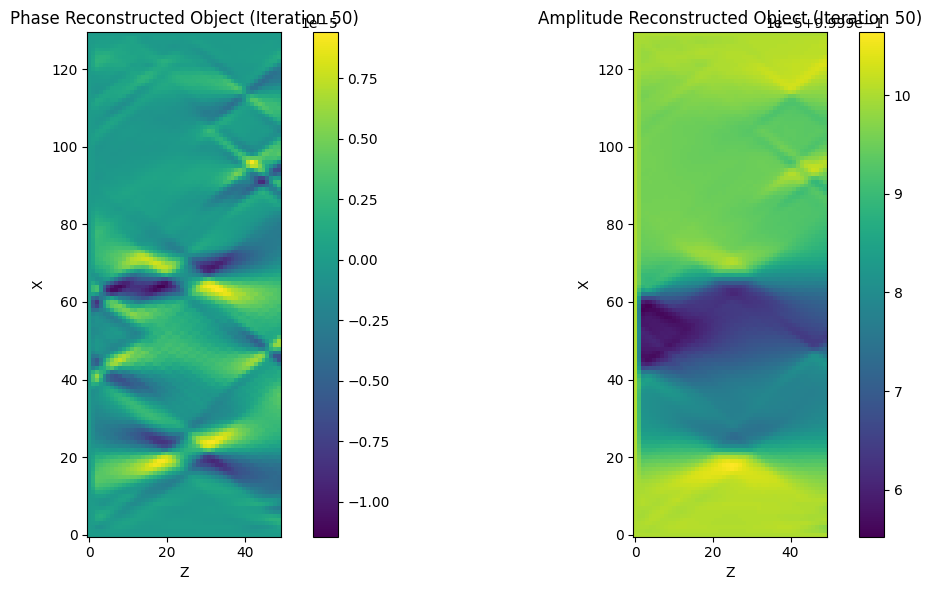

    Iteration 50 took 20.58 seconds.


In [7]:
max_iters = 50
reconstructed_sample_space, reconstructed_wave, residual_history = (
    least_squares.solve(max_iters=max_iters,
                        plot_forward=True,
                        plot_object=True,
                        fixed_step_size=None)
)

### 7. Visualise the Residual History and Final Iterations

Residual History of Least Squares Solve


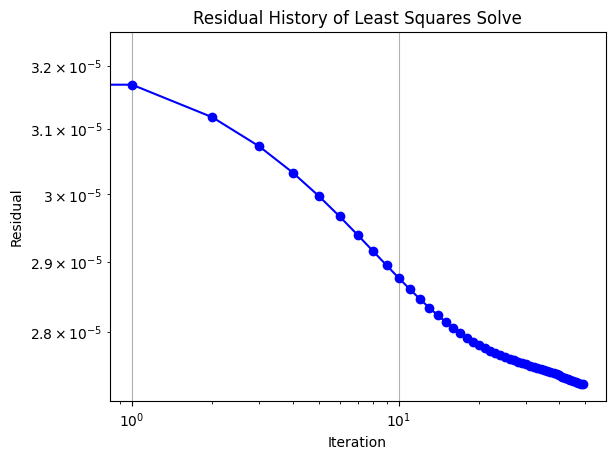

In [22]:
import matplotlib.pyplot as plt

# Log-log plot of residual
title ='Residual History of Least Squares Solve'
print(title)
plt.figure()
plt.loglog(residual_history, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title(title)
plt.grid(True)
plt.show()

Reconstructed Sample Space


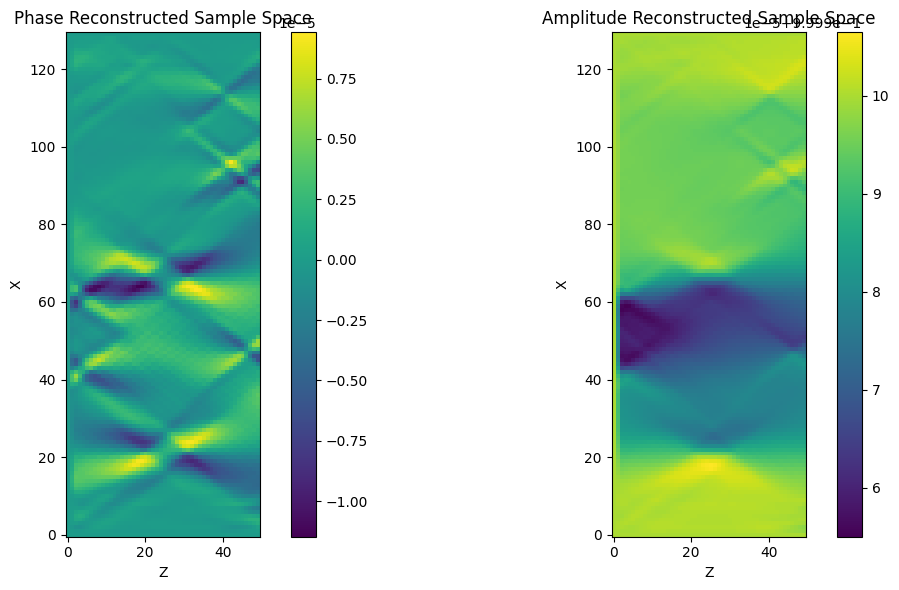

True Sample Space


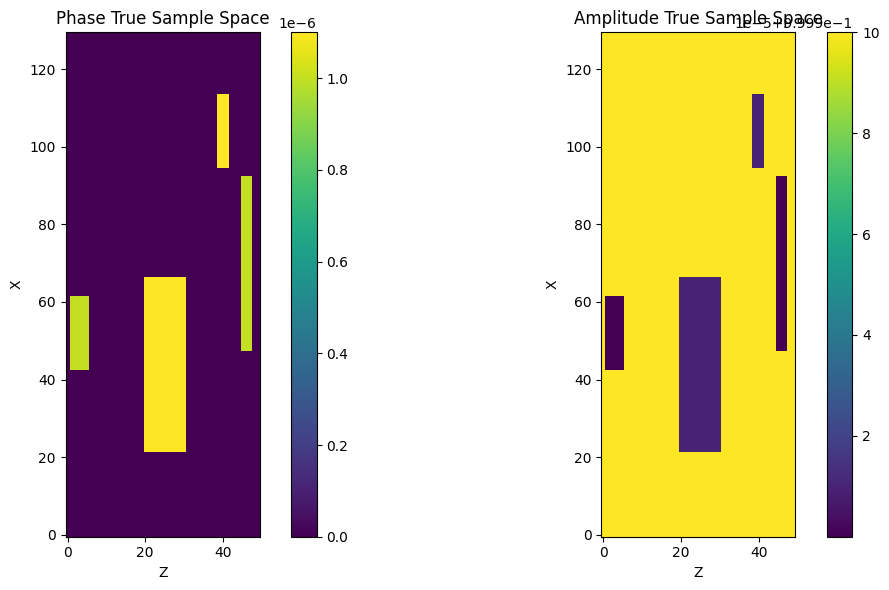

In [23]:
# Plot object field
title = "Reconstructed Sample Space"
print(title)
visualisation.plot(reconstructed_sample_space,title=title)

# Plot the true sample space
title = "True Sample Space"
print(title)
visualisation.plot(sample_space.n_true, title=title)

Reconstructed Wave


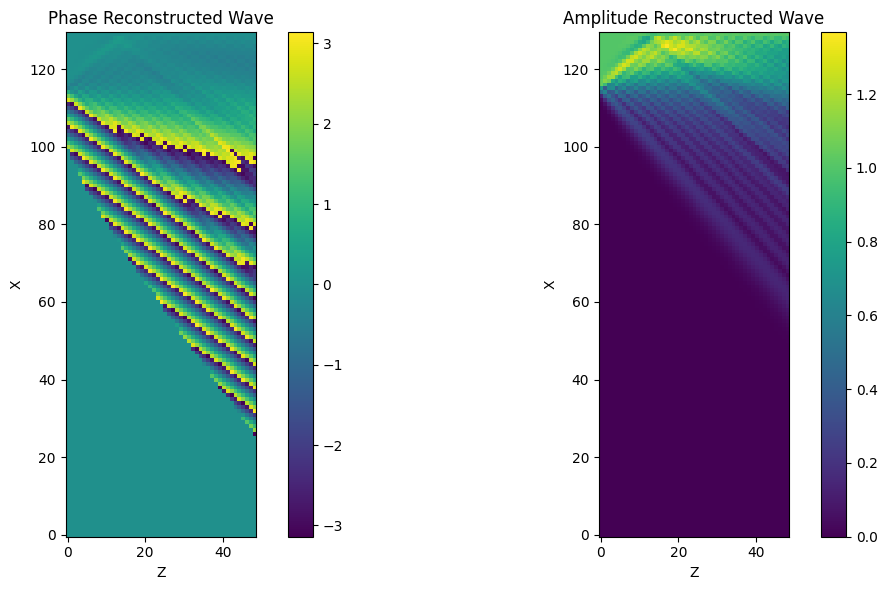

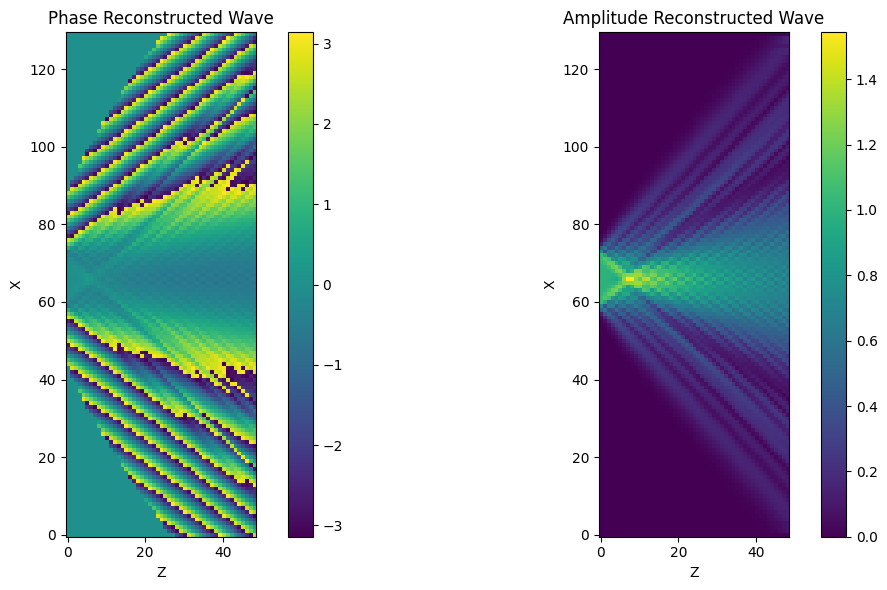

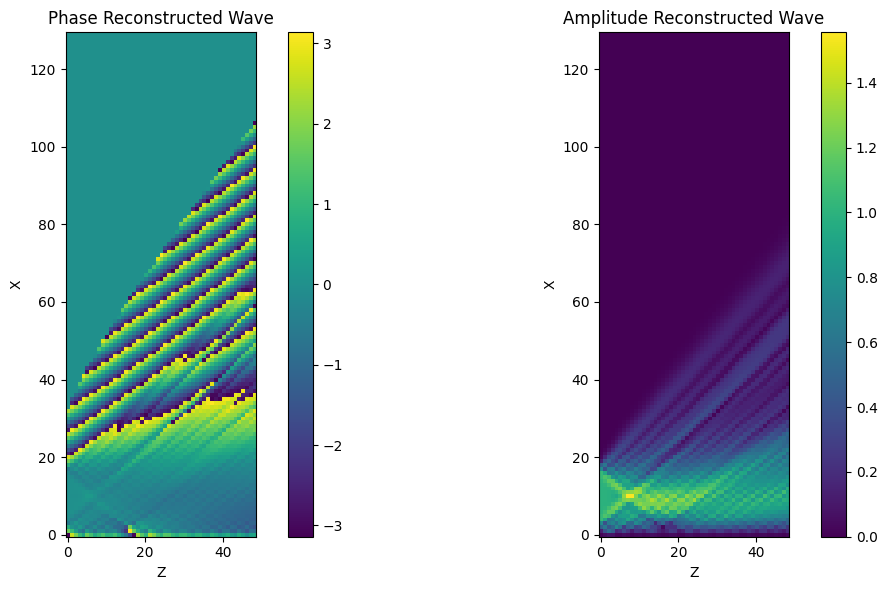

In [26]:
# Plot the reconstructed wave
title = "Reconstructed Wave"
print(title)
visualisation.plot(reconstructed_wave, title=title, probe_index=-1)
visualisation.plot(reconstructed_wave, title=title)
visualisation.plot(reconstructed_wave, title=title, probe_index=0)

In [9]:
# Profile the reconstruction
# %load_ext line_profiler
# %lprun -f SolveLeastSquares.compute_forward_model least_squares.solve(max_iters=max_iters, plot_forward=True, plot_object=True, fixed_step_size=False)